In [1]:
%load_ext autoreload
%autoreload 2


# `Logit` on Orders - A warm-up challenge (~1h)

## Select features

🎯 Let's figure out the impact of `wait_time` and `delay_vs_expected` on very `good/bad reviews`

👉 Using our `orders` training_set, we will run two `multivariate logistic regressions`:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

 

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


👉 Import your dataset:

In [14]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)


👉 Select in a list which features you want to use:

⚠️ Make sure you are not creating data leakage (i.e. selecting features that are derived from the target)

💡 To figure out the impact of `wait_time` and `delay_vs_expected` we need to control for the impact of other features, include in your list all features that may be relevant

<AxesSubplot:>

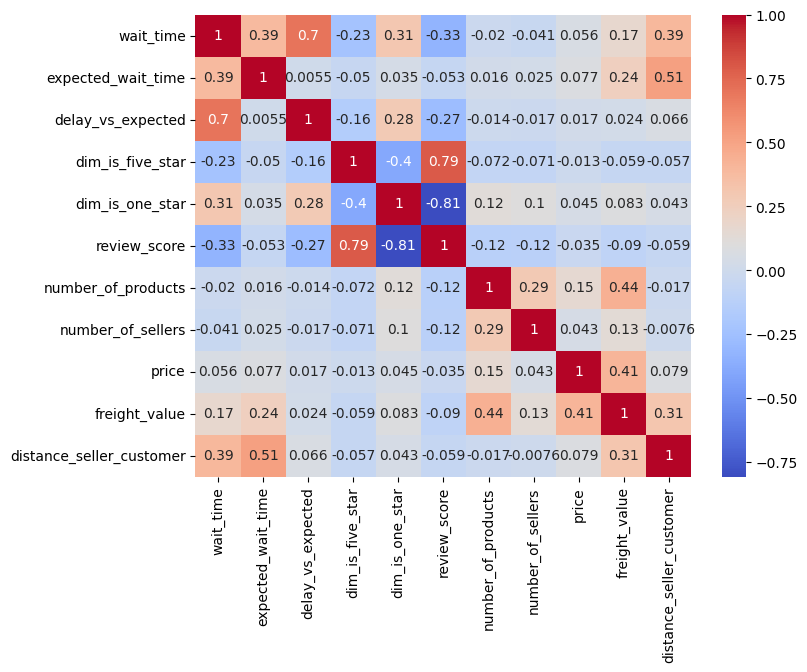

In [15]:
plt.figure(figsize = (8, 6))

sns.heatmap(
    orders.corr(),
    cmap = 'coolwarm',
    annot = True,
    annot_kws = {"size": 10}
)


In [60]:
features = ['wait_time', 'expected_wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers', 'price', 'freight_value', 'distance_seller_customer']


In [61]:
# Normalize the data
orders_scaled = orders.copy()

for feature in features:
    mu = orders_scaled[feature].mean()
    sigma = orders_scaled[feature].std()
    orders_scaled[feature] = orders_scaled[feature].apply(lambda x: (x-mu)/sigma)

orders_normalized_features = orders_scaled[['wait_time', 'expected_wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers', 'price', 'freight_value', 'distance_seller_customer']]
orders_normalized_features.describe()


,wait_time,expected_wait_time,delay_vs_expected,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
count,9.587200e+04,9.587200e+04,9.587200e+04,9.587200e+04,9.587200e+04,9.587200e+04,9.587200e+04,9.587200e+04
mean,6.833282e-17,6.542756e-16,1.163585e-17,-1.129493e-16,2.902292e-16,1.259933e-17,-1.422983e-17,-3.379584e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.267075e+00,-2.478869e+00,-1.617813e-01,-2.645951e-01,-1.125444e-01,-6.541191e-01,-1.057298e+00,-1.009843e+00
25%,-6.090611e-01,-6.173580e-01,-1.617813e-01,-2.645951e-01,-1.125444e-01,-4.371915e-01,-4.150170e-01,-6.951260e-01
50%,-2.442884e-01,-5.800516e-02,-1.617813e-01,-2.645951e-01,-1.125444e-01,-2.441477e-01,-2.597913e-01,-2.803050e-01
75%,3.327512e-01,5.333323e-01,-1.617813e-01,-2.645951e-01,-1.125444e-01,6.359577e-02,5.763123e-02,3.309108e-01
max,2.071296e+01,1.498844e+01,4.042054e+01,3.705941e+01,3.224085e+01,6.405892e+01,8.236302e+01,1.367858e+01


🕵🏻 Check the `multi-colinearity` of your features, using the `VIF index`.

* It shouldn't be too high (< 10 preferably) to ensure that we can trust the partial regression coefficents and their associated `p-values` 
* Do not forget to standardize your data ! 
    * A `VIF Analysis` is made by regressing a feature vs. the other features...
    * So you want to `remove the effect of scale` so that your features have an equal importance before running any linear regression!
    
    
📚 <a href="https://www.statisticshowto.com/variance-inflation-factor/">Statistics How To - Variance Inflation Factor</a>

📚  <a href="https://online.stat.psu.edu/stat462/node/180/">PennState - Detecting Multicollinearity Using Variance Inflation Factors</a>

⚖️ Standardizing:

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif(orders_normalized_features.values, 0)


3.060574508776732

👉 Run your VIF Analysis to analyze the potential multicolinearities:

In [38]:
orders_normalized_features.shape[1]


8

In [62]:
vif_analysis = pd.DataFrame()
vif_analysis['features'] = orders_normalized_features.columns
vif_analysis['vif_index'] = [vif(orders_normalized_features.values, i) for i in range(orders_normalized_features.shape[1])]
round(vif_analysis.sort_values(by="vif_index", ascending = False),2)


,features,vif_index
0,wait_time,3.06
2,delay_vs_expected,2.45
6,freight_value,1.68
1,expected_wait_time,1.60
7,distance_seller_customer,1.60
3,number_of_products,1.37
5,price,1.21
4,number_of_sellers,1.10


## Logistic Regressions

👉 Fit two `Logistic Regression` models:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

`Logit 1️⃣`

In [66]:
formula = 'dim_is_one_star ~ 1'
model_one_star = smf.logit(formula=formula, data=orders).fit()
model_one_star.params


Optimization terminated successfully.
         Current function value: 0.319891
         Iterations 6


Intercept   -2.223601
dtype: float64

`Logit 5️⃣`

In [68]:
formula = 'dim_is_five_star ~ 1'
model_five_star = smf.logit(formula=formula, data=orders).fit()
model_five_star.params


Optimization terminated successfully.
         Current function value: 0.676080
         Iterations 4


Intercept    0.372705
dtype: float64

💡 It's time to analyse the results of these two logistic regressions:

- Interpret the partial coefficients in your own words.
- Check their statistical significances with `p-values`
- Do you notice any differences between `logit_one` and `logit_five` in terms of coefficient importances?

In [72]:
formula = 'dim_is_one_star ~ wait_time + delay_vs_expected'
logit_one = smf.logit(formula=formula, data=orders).fit()
logit_one.params


Optimization terminated successfully.
         Current function value: 0.283196
         Iterations 7


Intercept           -3.193266
wait_time            0.059117
delay_vs_expected    0.072307
dtype: float64

In [71]:
formula = 'dim_is_five_star ~ wait_time + delay_vs_expected'
logit_five = smf.logit(formula=formula, data=orders).fit()
logit_five.params


Optimization terminated successfully.
         Current function value: 0.642678
         Iterations 7


Intercept            0.999549
wait_time           -0.046604
delay_vs_expected   -0.105796
dtype: float64

In [75]:
# Among the following sentences, store the ones that are true in the list below

# a = "delay_vs_expected influences five_star ratings even more than one_star ratings"
# b = "wait_time influences five_star ratings even more more than one_star"

your_name = 'Jaris'
your_answer = ["delay_vs_expected influences five_star ratings even more than one_star ratings"]


🧪 __Test your code__

In [76]:
from nbresult import ChallengeResult

result = ChallengeResult('logit',
    answers = your_answer
)
result.write()
print(result.check())



============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/jarisfenner/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/jarisfenner/code/Kaaykun/04-Decision-Science/04-Logistic-Regression/data-logit/tests
plugins: typeguard-2.13.3, asyncio-0.19.0, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_logit.py::TestLogit::test_question PASSED                           [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/logit.pickle

git commit -m 'Completed logit step'

git push origin master



<details>
    <summary>- <i>Explanations and advanced concepts </i> -</summary>


> _All other thing being equal, the `delay factor` tends to increase the chances of getting stripped of the 5-star even more so than it affect the chances of 1-star reviews. Probably because 1-stars are really targeting bad products themselves, not bad deliveries_
    
❗️ However, to be totally rigorous, we have to be **more careful when comparing coefficients from two different models**, because **they might not be based on similar populations**!
    We have 2 sub-populations here: (people who gave 1-stars; and people who gave 5-stars) and they may exhibit intrinsically different behavior patterns. It may well be that "happy-people" (who tends to give 5-stars easily) are less sensitive as "grumpy-people" (who shoot 1-stars like Lucky-Luke), when it comes to "delay", or "price"...

</details>


## Logistic vs. Linear ?

👉 Compare the coefficients obtained from:
- A `Logistic Regression` to explain `dim_is_five_star`
- A `Linear Regression` to explain `review_score` 

Make sure to use the same set of features for both regressions.  

⚠️ Check that both sets of coefficients  tell  "the same story".

> YOUR ANSWER HERE

In [83]:
formula = 'dim_is_five_star ~ wait_time + delay_vs_expected'
logit_five = smf.logit(formula=formula, data=orders).fit()
logit_five.params


Optimization terminated successfully.
         Current function value: 0.642678
         Iterations 7


Intercept            0.999549
wait_time           -0.046604
delay_vs_expected   -0.105796
dtype: float64

In [82]:
formula = 'review_score ~ wait_time + delay_vs_expected'
model_review = smf.ols(formula=formula, data=orders).fit()
model_review.params


Intercept            4.650219
wait_time           -0.038298
delay_vs_expected   -0.020530
dtype: float64

🏁 Congratulations! 

💾 Don't forget to commit and push your `logit.ipynb` notebook !